## Import required packages, print function with label

In [4]:
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction
import gzip
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, homogeneity_score, fowlkes_mallows_score
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

def print2(variable):
    """
    Prints the variable with the text 'This is [variable_name]'.
    
    Args:
        variable: The variable to be printed.
    """
    frame = inspect.currentframe().f_back
    variable_name = None
    for name, val in frame.f_locals.items():
        if val is variable:
            variable_name = name
            break
    print(f"This is {variable_name}:", variable)

## Download dataset and load first i sequences

In [2]:
# Path to your .fasta.gz file
file_path = r"C:\Users\m1lfslay3r6000\Music\ESS_569_Project\data\raw\Gradients1.KOK1606.PA.assemblies\gradients1.all_S02C1_0_2um.Trinity.fasta.gz"

# Initialize a list to store the first five sequences
sequences = []
sample_seq = 99
# Open the .fasta.gz file
with gzip.open(file_path, "rt") as fasta_file:  # Use "rt" mode for text reading
    # Parse the FASTA sequences
    for i, record in enumerate(SeqIO.parse(fasta_file, "fasta")):
    #for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append(record)  # Store the sequence in the list
        '''if i >= sample_seq:  # Limit to the first 5 sequences
            break'''

'''# Verify the stored sequences
for i, record in enumerate(sequences):
    print(f"Sequence {i+1}:")
    print(f"ID: {record.id}")
    print(f"Description: {record.description}")
    print(f"Sequence length: {len(record.seq)}\n")
'''

'# Verify the stored sequences\nfor i, record in enumerate(sequences):\n    print(f"Sequence {i+1}:")\n    print(f"ID: {record.id}")\n    print(f"Description: {record.description}")\n    print(f"Sequence length: {len(record.seq)}\n")\n'

## Filter, kmerization, and PCA

In [5]:
# Filter out sequences with GC content outside a certain range (e.g., 40% to 60%)
#filtered_sequences = []
'''for seq in sequences:
    if 0.4 < gc_fraction(seq.seq) < 0.6:
        filtered_sequences.append(seq)
'''
sample_size = 10000
filtered_sequences = random.sample(sequences, sample_size)
print(f"Filtered {len(filtered_sequences)} sequences based on GC content.")


# Function to generate k-mers from sequences
def kmerize(sequence, k=5):
    """Generate k-mers of length k from a given sequence."""
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    return ' '.join(kmers)

# Convert each sequence to k-mer strings (Assuming `filtered_sequences` is a list of sequences)
kmer_sequences = [kmerize(str(seq.seq), k=5) for seq in filtered_sequences]


Filtered 10000 sequences based on GC content.


In [6]:


# Use CountVectorizer to create a k-mer count matrix
vectorizer = CountVectorizer()
kmer_matrix = vectorizer.fit_transform(kmer_sequences)


# Convert to a dense matrix for easier viewing
kmer_matrix_dense = kmer_matrix.toarray()
print(f"K-mer count matrix shape: {kmer_matrix_dense.shape}")


# Perform K-means clustering on the k-mer count matrix
num_clusters = 5  # Chosen based on previous analysis
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(kmer_matrix_dense)



K-mer count matrix shape: (10000, 1024)


KMeans(n_clusters=5, random_state=42)

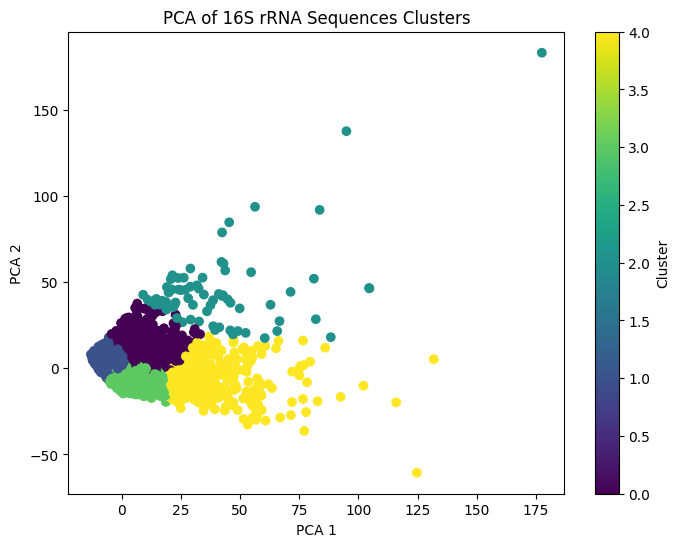

In [7]:

'''# Print the cluster assignments for the first #sample_seq sequences
for i in range(len(filtered_sequences)):
    print(f"Sequence {i+1} assigned to Cluster {kmeans.labels_[i]}")'''

# Perform PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(kmer_matrix_dense)

# Plot the PCA result, coloring by cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('PCA of 16S rRNA Sequences Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

## Silhouette and Elbow scores

Number of samples: 10000, Max k: 4


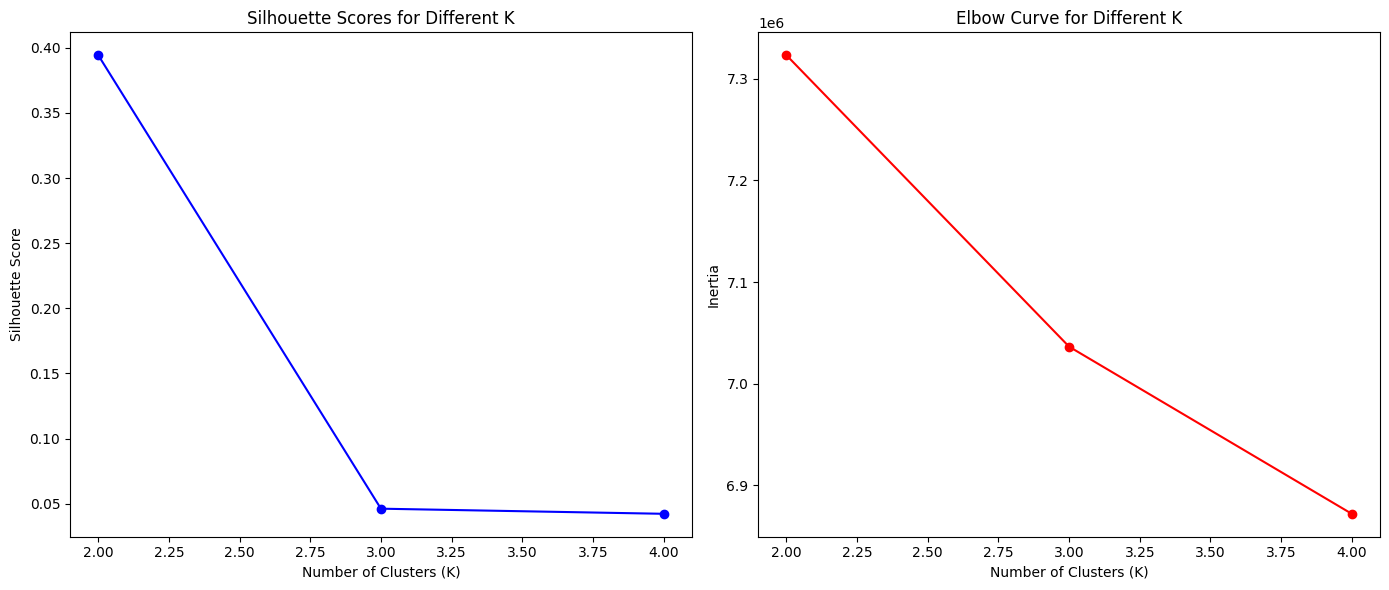

In [8]:
# Range of K values to test for silhouette analysis and elbow curve
k_values = range(2, 5)
silhouette_scores = []
inertia_values = []
print(f"Number of samples: {kmer_matrix_dense.shape[0]}, Max k: {max(k_values)}")
for k in k_values:
    # Fit KMeans for each value of K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(kmer_matrix_dense)
    
    # Calculate silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(kmer_matrix_dense, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # Store the inertia value (sum of squared distances to centroids)
    inertia_values.append(kmeans.inertia_)

# Plot Silhouette Scores and Inertia (Elbow Curve)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Silhouette Score
ax1.plot(k_values, silhouette_scores, marker='o', color='b')
ax1.set_title('Silhouette Scores for Different K')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Silhouette Score')

# Plot Inertia (Elbow Curve)
ax2.plot(k_values, inertia_values, marker='o', color='r')
ax2.set_title('Elbow Curve for Different K')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Inertia')

plt.tight_layout()
plt.show()

In [11]:
# Assuming you have ground truth labels (e.g., 'true_labels')
# If you don't have true labels, you can skip this evaluation part or simulate some labels.

n_samples = len(kmer_matrix_dense)  # Use the actual number of samples in your dataset
n_clusters = 5  # Define the number of clusters you want
# Generate 74 true labels across 3 clusters (simulate species categories)
np.random.seed(42)  # For reproducibility
true_labels = np.random.choice(['species_A', 'species_B', 'species_C', 'species D'], size=sample_size) # Replace with actual labels from metadata or taxonomic classificatio

## Homogeneity, Fowlkes-Mallows, Consistency Matrix, PCA 

Homogeneity Score: 0.0008
Fowlkes-Mallows Index: 0.3336
Pairwise consistency between runs (higher is better):
[[1.     0.1079 0.3772 0.5942 0.     0.1249 0.0013 0.0011 0.0935 0.4994]
 [0.1079 1.     0.0243 0.0843 0.0185 0.0283 0.4858 0.7561 0.5572 0.0542]
 [0.3772 0.0243 1.     0.0413 0.0249 0.0999 0.0942 0.0602 0.0062 0.0091]
 [0.5942 0.0843 0.0413 1.     0.002  0.3293 0.0332 0.0216 0.4796 0.4758]
 [0.     0.0185 0.0249 0.002  1.     0.516  0.0073 0.1306 0.0285 0.0166]
 [0.1249 0.0283 0.0999 0.3293 0.516  1.     0.0189 0.0024 0.3045 0.0279]
 [0.0013 0.4858 0.0942 0.0332 0.0073 0.0189 1.     0.5623 0.5183 0.3537]
 [0.0011 0.7561 0.0602 0.0216 0.1306 0.0024 0.5623 1.     0.4817 0.0014]
 [0.0935 0.5572 0.0062 0.4796 0.0285 0.3045 0.5183 0.4817 1.     0.    ]
 [0.4994 0.0542 0.0091 0.4758 0.0166 0.0279 0.3537 0.0014 0.     1.    ]]


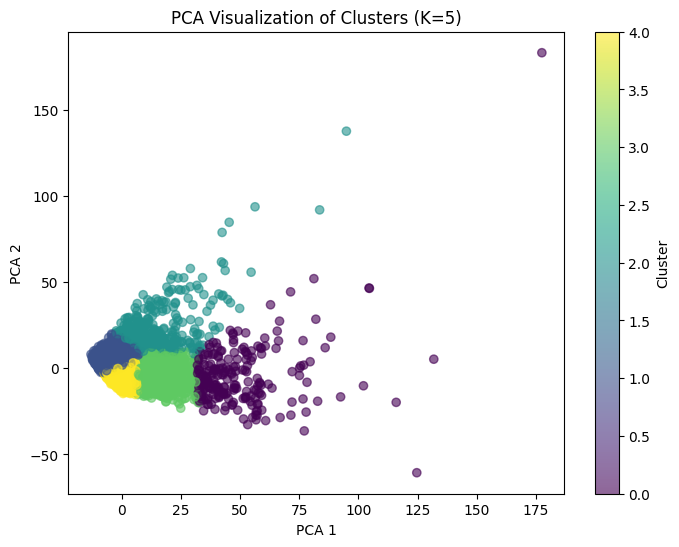

In [12]:
# Evaluate Homogeneity
homogeneity = homogeneity_score(true_labels, kmeans.labels_)
print(f"Homogeneity Score: {homogeneity:.4f}")


# Evaluate Fowlkes-Mallows Index
fmi = fowlkes_mallows_score(true_labels, kmeans.labels_)
print(f"Fowlkes-Mallows Index: {fmi:.4f}")

# Run K-means multiple times to test stability
num_runs = 10
k = 5  # Chosen based on previous analysis
cluster_labels = []

for i in range(num_runs):
    kmeans = KMeans(n_clusters=k, random_state=i)
    kmeans.fit(kmer_matrix_dense)
    cluster_labels.append(kmeans.labels_)

# Calculate pairwise consistency between runs
pairwise_consistency = np.zeros((num_runs, num_runs))


# Calculate consistency between every pair of runs
for i in range(num_runs):
    for j in range(i, num_runs):
        consistency = np.sum(cluster_labels[i] == cluster_labels[j]) / len(cluster_labels[i])
        pairwise_consistency[i, j] = consistency
        pairwise_consistency[j, i] = consistency

# Print out the consistency matrix
print(f"Pairwise consistency between runs (higher is better):\n{pairwise_consistency}")


# Perform PCA to reduce the dimensions to 2D for visualization
pca_result = pca.fit_transform(kmer_matrix_dense)

# Plot the 2D PCA results, coloring by KMeans cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.title(f'PCA Visualization of Clusters (K={k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()